<a href="https://colab.research.google.com/github/fun2play/BU_RISE_Project/blob/main/CFC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross Frequency Coupling (Phase Amplitude)

In [ ]:
import numpy as np
import mne
import matplotlib.pyplot as plt
import pandas as pd
from HFODetector import ste
from pathlib import Path

In [ ]:
import mne
raw = mne.io.read_raw_edf("sub-01_ses-01_task-hfo_run-01_eeg.edf", preload=True)
print(raw.info['sfreq'])

Extracting EDF parameters from /home/user96/sub-01_ses-01_task-hfo_run-01_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 599999  =      0.000 ...   300.000 secs...
2000.0


In [ ]:

if __name__ == "__main__":
    edf_path = "sub-01_ses-01_task-hfo_run-01_eeg.edf" #change this to your edf path
    detector = ste.STEDetector(
        sample_freq=2000,
        filter_freq=[80, 500],
        rms_window=3*1e-3,
        min_window=6*1e-3,
        min_gap=10 * 1e-3,
        epoch_len=600,
        min_osc=6,
        rms_thres=5,
        peak_thres=3,
        n_jobs=32,
        front_num=1
    )
    channel_names, start_end = detector.detect_edf(edf_path)
    # channel_names is a list that is the same length as the number of channels in the edf
    # start_end is a nested list with the same length as channel_names. start_end[i][j][0] and start_end[i][j][1]
    # will give the start and end index respectively for the jth detected HFO in channel channel_names[i]
    channel_names = np.concatenate([[channel_names[i]]*len(start_end[i]) for i in range(len(channel_names))])
    start_end = [start_end[i] for i in range(len(start_end)) if len(start_end[i])>0]
    start_end = np.concatenate(start_end)
    HFO_ste_df = pd.DataFrame({"channel":channel_names,"start":start_end[:,0],"end":start_end[:,1]})

Extracting EDF parameters from /home/user96/sub-01_ses-01_task-hfo_run-01_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|████████████████████████████████████████| 51.0/51.0 [00:01<00:00, 47.6it/s]


In [ ]:
start_end

array([[365560, 365616],
       [365743, 365836],
       [340187, 340224],
       [365558, 365618],
       [365741, 365840],
       [365570, 365710],
       [212414, 212458],
       [365560, 365605],
       [365735, 365838],
       [     0,     27],
       [340189, 340233],
       [107757, 107801],
       [238968, 239008],
       [507408, 507450],
       [349798, 349848],
       [596712, 596749],
       [365559, 365646],
       [365741, 365839],
       [286226, 286264],
       [340188, 340224],
       [365570, 365629],
       [365650, 365707],
       [426007, 426043],
       [     0,     26]])

In [ ]:
from scipy.io import savemat
raw.pick('eeg')  # drop EOG, EMG, etc.

# 2. Extract data array, times, and channel names
data, times = raw.get_data(return_times=True)
chan_names = raw.ch_names

# 2) Notch at 60 Hz + harmonics
#raw.notch_filter(freqs=[60., 120., 180.], picks='all')

# 3) High-pass at 1 Hz to kill slow drifts
raw.filter(l_freq=1.0, h_freq=None, picks='all')

# 4. Re-extract now-filtered data
data, times = raw.get_data(return_times=True)

# 5. Remove channel-wise mean to center each trace at zero
import numpy as np
mean_per_chan = np.mean(data, axis=1, keepdims=True)
data_centered = data - mean_per_chan



# 3. Write to .mat
savemat_path = 'cleaned_060_ictal_1_ieeg.mat'
savemat(savemat_path, {
    'data': data_centered,
    'times': times,
    'chan_names': chan_names
})
print(f"Saved EEG to {savemat_path}")

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)

Saved EEG to cleaned_060_ictal_1_ieeg.mat


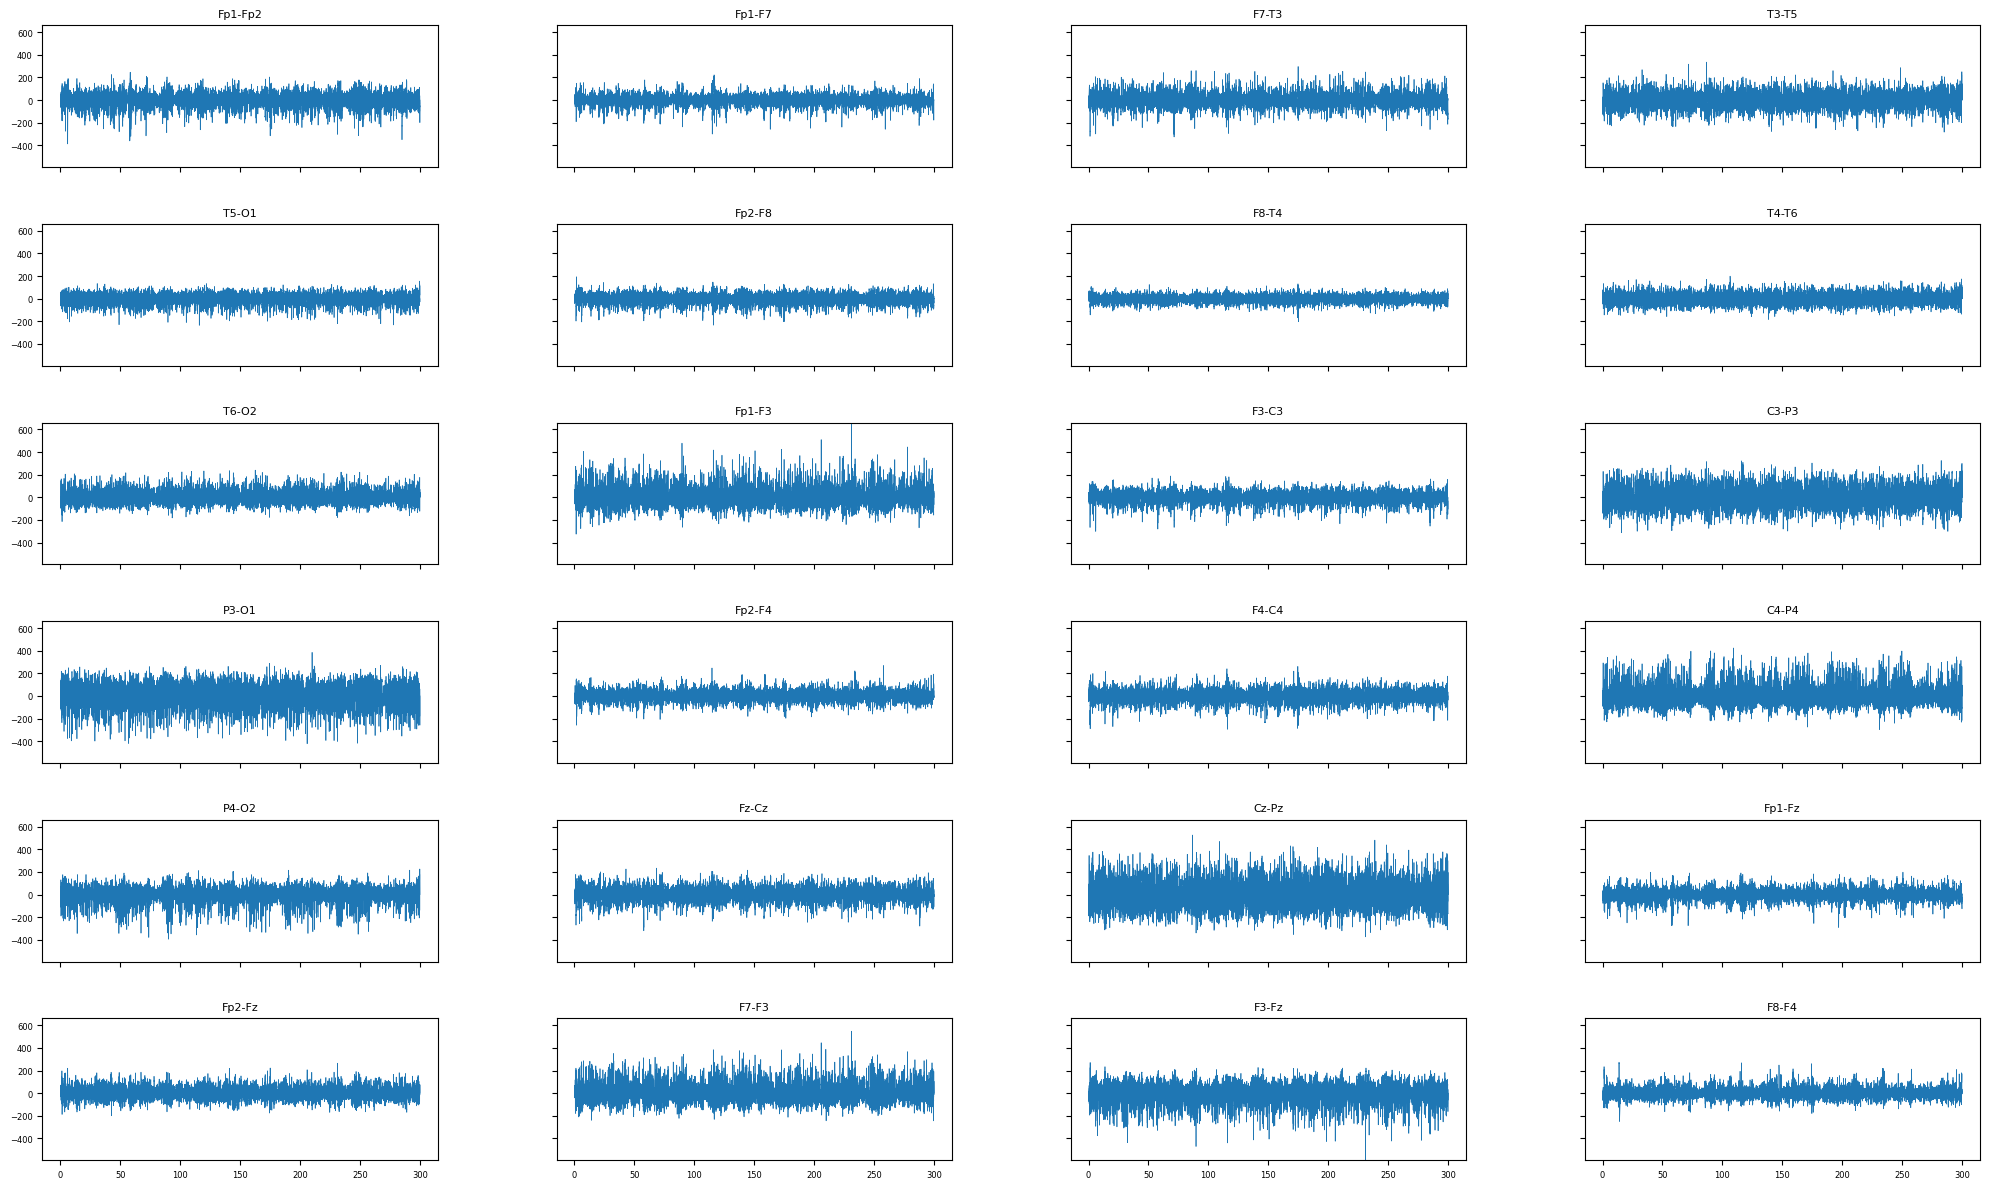

In [ ]:
n_channels = data.shape[0]
n_rows, n_cols = 6, 4
n_axes = n_rows * n_cols
n_plots    = min(n_axes, n_channels)


fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(20, 12),
                         sharex=True, sharey=True)
axes = axes.flatten()

for i in range(n_plots):
    ax = axes[i]
    ax.plot(times, data[i], linewidth=0.5)
    ax.set_title(chan_names[i], fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.set_ylim(data.min(), data.max())  # common y‐range

# Turn off any unused subplots
for ax in axes[n_plots:]:
    ax.axis('off')

fig.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

In [ ]:
from spectral_connectivity import Multitaper, Connectivity
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

In [ ]:
# Frequency filtering for PAC
freq_phase = [4, 8]  #Theta band phase
raw_phase = raw.copy().filter(l_freq=freq_phase[0], h_freq=freq_phase[1], picks='eeg')
freq_amp = [80, 150]  #Gamma band amplitude
raw_amp = raw.copy().filter(l_freq=freq_amp[0], h_freq=freq_amp[1], picks='eeg')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 3301 samples (1.651 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 80 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 80.00
- Lower transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 70.00 Hz)
- Upper passband e

In [ ]:
from scipy.signal import hilbert

data_phase, _ = raw_phase.get_data(return_times=True)
data_amp, _ = raw_amp.get_data(return_times=True)

# Apply Hilbert transform and extract instantaneous phase
analytic_signal_phase = hilbert(data_phase)
phase_data = np.angle(analytic_signal_phase)

# Apply Hilbert transform and extract instantaneous amplitude
analytic_signal_amp = hilbert(data_amp)
amplitude_data = np.abs(analytic_signal_amp)

In [ ]:
# Calculate Mean Vector Length (MVL) for each channel
pac_values = []
n_channels = data_phase.shape[0]

for i in range(n_channels):
    complex_vectors = amplitude_data[i] * np.exp(1j * phase_data[i])
    mvl = np.abs(np.mean(complex_vectors))
    pac_values.append(mvl)

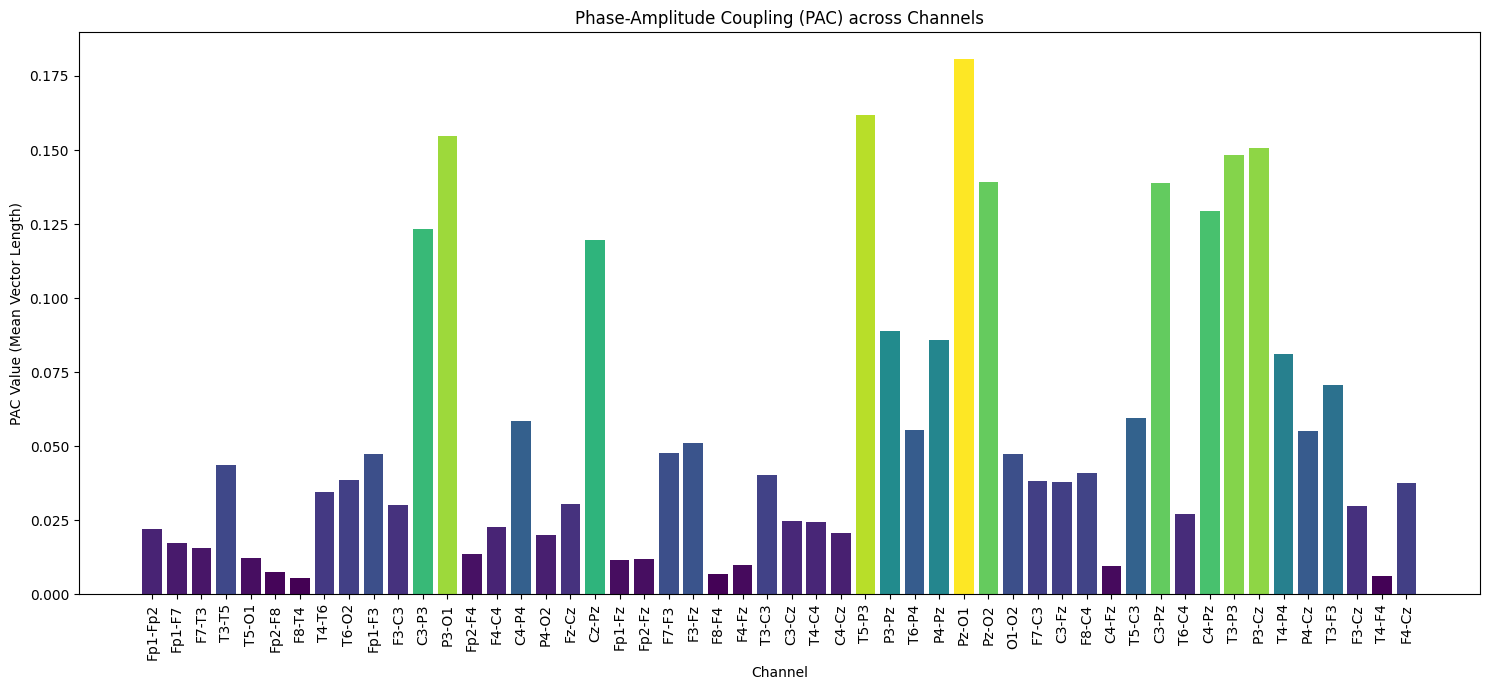

In [ ]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

cmap = plt.cm.viridis
norm = Normalize(vmin=np.min(pac_values), vmax=np.max(pac_values))

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(pac_values)

fig, ax = plt.subplots(figsize=(15, 7))
bars = ax.bar(chan_names, pac_values, color=cmap(norm(pac_values)))

ax.set_xticks(np.arange(len(chan_names)))
ax.set_xticklabels(chan_names, rotation=90)

ax.set_title("Phase-Amplitude Coupling (PAC) across Channels")
ax.set_xlabel("Channel")
ax.set_ylabel("PAC Value (Mean Vector Length)")

# cbar = fig.colorbar(sm, ax=ax)
# cbar.set_label("PAC Value (Mean Vector Length)")

fig.tight_layout()

plt.show()